# **Prepare datasets**

Kita akan memakai dataset NusaX dari paper [berikut](https://arxiv.org/pdf/2205.15960.pdf). Dataset bisa diunduh di [sini](https://drive.google.com/drive/folders/1z1V_dGuEgjZJ2RiauaEcGLkHjBMAwcuO?usp=sharing). Di dalamnya terdapat "train.csv", "valid.csv", dan "test.csv". 

Setelah kita download dataset, kita upload ke Google Colab. Setelah itu kita panggil dengan Pandas dan karena file nya terpisah, kita gabung menjadi 1. 

In [1]:
import pandas as pd

df_train = pd.read_csv('/content/train.csv')
df_valid = pd.read_csv('/content/valid.csv')

df = df_train.append(df_valid, ignore_index=True)

In [2]:
df_test = pd.read_csv('/content/test.csv')

df = df.append(df_test, ignore_index=True)

Kita cek isi datasetnya dan di dalamnya terdapat 1000 data. Terdiri dari:


*   Positive: 378
*   Neutral: 239
*   Negative: 383



In [3]:
df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [4]:
df.shape

(1000, 3)

In [5]:
df.label.value_counts()

negative    383
positive    378
neutral     239
Name: label, dtype: int64

# **Text Normalization/Cleansing**

Lalu kita lakukan cleansing sebagai berikut

In [6]:
import nltk  
nltk.download('stopwords')  
from nltk.corpus import stopwords as stopwords_scratch

# Pada Cleansing kali ini kita menggunakan Stopwords untuk menghilangkan kata yang tidak diperlukan

# panggil stopword id
list_stopwords = stopwords_scratch.words('indonesian')
# panggil stopword en
list_stopwords_en = stopwords_scratch.words('english')
# gabungkan id & en
list_stopwords.extend(list_stopwords_en)
# tambah daftar stopword jika perlu
list_stopwords.extend(['ya', 'yg', 'ga', 'yuk', 'dah'])
stopwords = list_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
stopwords[:3]

['ada', 'adalah', 'adanya']

# Feature Extraction: TF-IDF

Setelah itu kita lakukan Feature Extraction menggunakan metode TF-IDF

In [8]:
# Untuk melakukan Feature Extraction, kita menggunakan library "Sklearn atau scikit-learn".
# Sklearn adalah library untuk melakukan task-task Machine Learning.
# "TfidfVectorizer" merupakan salah satu modul untuk melakukan "BoW"

from sklearn.feature_extraction.text import TfidfVectorizer

# Kita proses Feature Extraction
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(df.text.to_list())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  % sorted(inconsistent)


# Training

Jalankan training dengan metode K-Means menggunakan library Sklearn. Pada training kali ini kta menentukan cluster sebanyak 2.

In [9]:
from sklearn.cluster import KMeans

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=2, n_init=1)

Setelah kita lakukan training, kita uraikan teks yang sudah terkluster untuk melihat outputnya. Dengan melihat outputnya, kita sekaligus melihat apakah kluster yang kita pilih sudah tepat atau belum.

In [10]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
  print("Cluster %d:" % i),
  for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])
  print()

Cluster 0:
 orang
 banget
 harga
 marah
 pelayanan
 pagi
 pesan
 jalan
 macet
 bikin

Cluster 1:
 enak
 makan
 makanan
 tempatnya
 makanannya
 nyaman
 menu
 restoran
 harga
 malam



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Evaluation

Untuk evaluasi kita menggunakan Silhouette Score. Nilai terbaik adalah 1 dan nilai terburuk adalah -1. Nilai di dekat 0 menunjukkan kluster tumpang tindih. Nilai negatif umumnya menunjukkan bahwa sampel telah diberikan pada kelompok yang salah, karena kelompok yang berbeda lebih mirip.

In [11]:
from sklearn.metrics import silhouette_score

silhouette_score(X, labels=model.predict(X))

0.004759696028481793

Silhouette Score yang kita dapat adalah 0.0049, dimana ini menunjukkan terdapat data berada kelompok yang salah karena mendekati 0.

Guna mengonfirmasi nilai di atas, kita bisa memvisualisasikan hasil kluster seperti berikut:

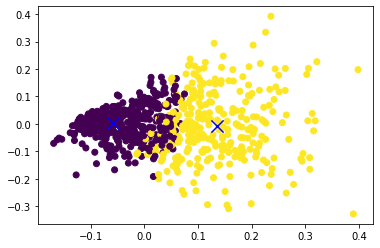

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(X.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

Hasilnya memang terdapat data yang masuk ke kluster yang salah.